# Binary Class Challenge: Skin Lesion Classification Using Deep Learning
Author: **Mohammad Imran Hossain**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master in Medical Imaging and Applications


<br>We have explored the Transfer Learning technique to classiy the skin lesion from the darmoscopic images. The dataset consists of two classes (nevus and others).
<br>- Training Data   - 15195
<br>- Validation Data - 3796
<br>- Testing Data    - 6340

# Necessary Libraries

In [5]:
# Standard libraries
import os
import sys
import time
import logging
import copy

# Data handling and numerical operations
import numpy as np
from PIL import Image

# Machine Learning and PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from torch.hub import load_state_dict_from_url

# Torchvision for models and transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b2, efficientnet_b4
from torchvision.models import swin_b, swin_v2_t
from torchvision.models import EfficientNet_B2_Weights, EfficientNet_B4_Weights
from torchvision.models import Swin_B_Weights, Swin_V2_T_Weights

# Data augmentation
import albumentations as Alb
from albumentations.pytorch import ToTensorV2

# Metrics and visualization
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Mount Colab


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Check GPU information
!nvidia-smi

Wed Dec 27 10:39:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Exploratory Data Analysis

In [3]:
# Define the path of the train and validation dataset directories
TRAIN_DATA_PATH   = '/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Binary_Class/Dataset/train'
VALID_DATA_PATH   = "/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Binary_Class/Dataset/val"
TEST_DATA_PATH    = '/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Binary_Class/Dataset/test'

# Define the path for saving the best model
TENSORBOARD_PATH  = '/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Binary_Class/Logs'
BEST_MODEL_PATH   = "/content/drive/MyDrive/Colab_Notebooks/CADx/Skin_Lesion_Classification_Deep_Learning_Binary_Class/Models"

In [ ]:
# Function to preprocess image
def preprocess_image(image_path):
    # Function to preprocess an image given its path
    """
    Preprocess an image from the given path.

    Args:
    image_path (str): Path to the image file.

    Returns:
    torch.Tensor: Transformed image as a tensor.
    """
    # Open the image file at the specified path
    image = Image.open(image_path)
    # Define transformations: resize to 256x256 and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    # Apply the transformations to the image
    return transform(image)


# Function to compute the mean and standard deviation of intensities of training dataset
def calculate_mean_std(data_path):
    # Function to calculate the mean and standard deviation of images in a dataset
    """
    Calculate mean and standard deviation of images in a dataset.

    Args:
    data_path (str): Path to the dataset directory.

    Returns:
    tuple: Mean and standard deviation of the dataset images.
    """
    # Initialize variables for mean and standard deviation calculation
    channel_sum, channel_squared_sum = np.zeros(3), np.zeros(3)
    num_images = 0

    # Iterate over each image file in the dataset
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.jpg'):
                # Process each image and update the sum and squared sum
                image_path = os.path.join(root, file)
                img = preprocess_image(image_path)
                channel_sum += torch.mean(img, dim=[1, 2]).numpy()
                channel_squared_sum += torch.mean(img**2, dim=[1, 2]).numpy()
                num_images += 1

    # Calculate the mean and standard deviation
    mean = channel_sum / num_images
    stddev = (channel_squared_sum / num_images - mean**2)**0.5
    return mean, stddev

# Apply the function to calculate mean and std deviation for a dataset
computed_mean, computed_std = calculate_mean_std(TRAIN_DATA_PATH)

# Display the computed mean and standard deviation
print("Training Dataset  :")
print("Mean              :", computed_mean)
print("Standard Deviation:", computed_std)


Training Dataset  :
Mean              : [0.66755675 0.52953318 0.52441606]
Standard Deviation: [0.22344251 0.20344295 0.21513982]


In [4]:
# Class for load the data
class SkinLesionDataset(Dataset):
    def __init__(self, root_dir, img_height, img_width, img_transform=None, augment=False, has_subfolders=True):
        """
        Initializes the SkinLesionDataset object.
        Args:
            root_dir (string): Directory with all the images.
            img_height (int): The desired image height.
            img_width (int): The desired image width.
            img_transform (callable, optional): Optional transform to be applied on a sample.
            augment (boolean): Whether to perform data augmentation or not.
            has_subfolders (boolean): Whether the dataset has subfolders for each class.
        """
        self.root_dir = root_dir
        self.img_height = img_height
        self.img_width = img_width
        self.img_transform = img_transform
        self.augment = augment
        self.classes = ['nevus', 'others']
        self.file_list = []
        self.labels = []

        if has_subfolders:
            for index, _class in enumerate(self.classes):
                class_path = os.path.join(self.root_dir, _class)
                for img in os.listdir(class_path):
                    self.file_list.append((os.path.join(class_path, img), index))
                    self.labels.append(index)
        else:
            # Assuming files are named such that they sort correctly from xxx00001 onwards
            for img in sorted(os.listdir(self.root_dir), key=lambda x: int(x.split('.')[0][-5:])):
                self.file_list.append((img, None))  # None for no label

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path, label = self.file_list[idx]

        # Append root_dir for test dataset
        if label is None:
            img_path = os.path.join(self.root_dir, img_path)
        image = np.array(Image.open(img_path).convert('RGB'))


        if self.augment:
            aug_transform = Alb.Compose([
                Alb.SmallestMaxSize(max_size=max(self.img_height, self.img_width)),
                Alb.RandomResizedCrop(height=self.img_height, width=self.img_width, scale=(0.4, 1.0), ratio=(0.75, 4/3)),
                Alb.Affine(scale=(0.8, 1.2), rotate=(0.0, 90.0), shear=(0.0, 20.0), p=0.8),
                Alb.Flip(p=0.9),
                Alb.ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.9, 1.1], hue=0.05, p=0.6),
            ])
            image = aug_transform(image=image)['image']

        if self.img_transform:
            image = self.img_transform(Image.fromarray(image))

            # Modify this part for handling test data
        if label is None:
        # The full path is already constructed in __init__
           return image, img_path

        return image, label, img_path


    def get_labels(self):
        return self.labels


# Compute the mean and standard deviation of intensites of the dataset
IMAGE_SIZE = 256
MU       = [0.485, 0.456, 0.406]
STD      = [0.229, 0.224, 0.225]



# Image transformation
img_transforms = transforms.Compose([
                                     transforms.Resize(IMAGE_SIZE+4),
                                     transforms.CenterCrop(IMAGE_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean= MU, std=STD)
                                    ])


# Define image dimensions
IMAGE_HEIGHT = 256
IMAGE_WIDTH  = 256

# Load datasets with defined image dimensions
train_dataset = SkinLesionDataset(root_dir=TRAIN_DATA_PATH, img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, img_transform=img_transforms, augment=True, has_subfolders= True)
val_dataset   = SkinLesionDataset(root_dir=VALID_DATA_PATH, img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, img_transform=img_transforms, augment=False, has_subfolders= True)
test_dataset  = SkinLesionDataset(root_dir=TEST_DATA_PATH, img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, img_transform=img_transforms, augment=False, has_subfolders= False)

# Define the Batch Size
BATCH_SIZE = 16

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)



In [ ]:
# Function to count number of dataset for each class
def count_classes(dataset):
    nevus_count = 0
    others_count = 0
    for _, label in tqdm(dataset, desc="Counting"):
        if label == 0:  # Assuming 'nevus' is indexed as 0
            nevus_count += 1
        elif label == 1:  # Assuming 'others' is indexed as 1
            others_count += 1
    return nevus_count, others_count

# Count for training dataset
train_nevus_count, train_others_count = count_classes(train_dataset)
print("Total Number of Training Data:", len(train_dataset))
print("Nevus:", train_nevus_count)
print("Others:", train_others_count)
print("\n")

# Count for validation dataset
val_nevus_count, val_others_count = count_classes(val_dataset)
print("\nTotal Number of Validation Data:", len(val_dataset))
print("Nevus:", val_nevus_count)
print("Others:", val_others_count)


Counting: 100%|██████████| 15195/15195 [06:48<00:00, 37.24it/s]


Total Number of Training Data: 15195
Nevus: 7725
Others: 7470




Counting: 100%|██████████| 3796/3796 [01:32<00:00, 41.14it/s]


Total Number of Validation Data: 3796
Nevus: 1931
Others: 1865


# Training Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, checkpoint_path='model_checkpoint.pth', start_epoch=0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0
    early_stop_patience = 10

    # Dictionary to store metrics for plotting
    metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.squeeze()
                    loss = criterion(outputs, labels.float())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).round()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Record the metrics
            if phase == 'train':
                metrics['train_loss'].append(epoch_loss)
                metrics['train_acc'].append(epoch_acc.item())
            else:
                metrics['val_loss'].append(epoch_loss)
                metrics['val_acc'].append(epoch_acc.item())

                # Check if validation loss has improved
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), checkpoint_path)  # Save the best model checkpoint
                    early_stop_counter = 0  # Reset counter since we found a better model
                else:
                    early_stop_counter += 1  # Increment counter if no improvement

                # Check if early stopping is triggered
                if early_stop_counter > early_stop_patience:
                    print('\nEarly stopping')
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    print('Best val loss: {:4f}'.format(best_loss))
                    model.load_state_dict(best_model_wts)
                    return model, metrics

                scheduler.step(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)

    return model, metrics


# Prediction Model

In [20]:
def predict_model(model, dataloader, criterion, DEVICE='cuda'):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_probs = []  # Store probability scores
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            if len(batch) == 2:
                inputs, labels = batch
            elif len(batch) > 2:
                inputs, labels = batch[:2]
            else:
                raise ValueError("Batch from DataLoader does not have the expected format.")

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float())

            running_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs)  # Get probabilities
            preds = probs.round()
            running_corrects += torch.sum(preds == labels.data)

            all_probs.extend(probs.cpu().numpy())  # Collect probabilities
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_kappa = cohen_kappa_score(all_labels, [p.round() for p in all_probs])

    end_time = time.time()
    total_time = end_time - start_time

    print(f"\nTotal prediction time: {total_time:.2f} seconds")

    # Return probabilities along with other metrics
    return all_probs, all_labels, test_loss, test_acc, test_kappa


# Visualization

In [24]:
def plot_evaluation_metrics(y_true, y_probs, class_names=None):
    # Convert y_probs to a NumPy array if it's not already
    y_probs = np.array(y_probs)

    # Convert probabilities to binary predictions
    y_pred = (y_probs >= 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    print('\n')
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


# ResNet34 Model

In [ ]:
# Setup for logging
logging.basicConfig(filename="training_log.txt", level=logging.INFO, force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Creating ResNet34 model
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
resnet34_model = model.to(DEVICE)

# Additional required parameters
LR = 1e-4
WD = 1e-8
EPOCHS = 100

# Loss function, Optimizer, and LR Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

# TensorBoard setup
writer_path  = TENSORBOARD_PATH + '/tensorboard_log'
train_writer = SummaryWriter(writer_path + '/train')
val_writer   = SummaryWriter(writer_path + '/val')

# DataLoaders
dataloaders = {"train": train_loader, "val": val_loader}

# Set your checkpoint path
checkpoint_path = TENSORBOARD_PATH + '/resnet34_checkpoint.pth'

# Check if a checkpoint exists, if so, load it
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    resnet34_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch

# Train the model
summary = train_model(resnet34_model,
                      dataloaders,
                      criterion,
                      optimizer,
                      lr_scheduler,
                      num_epochs=EPOCHS,
                      checkpoint_path=checkpoint_path,
                      start_epoch=start_epoch)

# Close the train and validation writers
train_writer.close()
val_writer.close()

Epoch 0/99
----------


100%|██████████| 475/475 [06:37<00:00,  1.19it/s]


train Loss: 0.4383 Acc: 0.7996


100%|██████████| 119/119 [01:31<00:00,  1.31it/s]


val Loss: 0.3794 Acc: 0.8380
Epoch 1/99
----------


100%|██████████| 475/475 [06:41<00:00,  1.18it/s]


train Loss: 0.3938 Acc: 0.8247


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3692 Acc: 0.8390
Epoch 2/99
----------


100%|██████████| 475/475 [07:06<00:00,  1.11it/s]


train Loss: 0.3708 Acc: 0.8355


100%|██████████| 119/119 [01:40<00:00,  1.19it/s]


val Loss: 0.3462 Acc: 0.8530
Epoch 3/99
----------


100%|██████████| 475/475 [07:04<00:00,  1.12it/s]


train Loss: 0.3586 Acc: 0.8448


100%|██████████| 119/119 [01:33<00:00,  1.27it/s]


val Loss: 0.3780 Acc: 0.8285
Epoch 4/99
----------


100%|██████████| 475/475 [06:59<00:00,  1.13it/s]


train Loss: 0.3440 Acc: 0.8511


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.3172 Acc: 0.8625
Epoch 5/99
----------


100%|██████████| 475/475 [06:51<00:00,  1.15it/s]


train Loss: 0.3346 Acc: 0.8552


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3261 Acc: 0.8614
Epoch 6/99
----------


100%|██████████| 475/475 [06:45<00:00,  1.17it/s]


train Loss: 0.3292 Acc: 0.8579


100%|██████████| 119/119 [01:28<00:00,  1.34it/s]


val Loss: 0.3279 Acc: 0.8541
Epoch 7/99
----------


100%|██████████| 475/475 [06:48<00:00,  1.16it/s]


train Loss: 0.3194 Acc: 0.8603


100%|██████████| 119/119 [01:39<00:00,  1.19it/s]


val Loss: 0.3196 Acc: 0.8654
Epoch 8/99
----------


100%|██████████| 475/475 [07:16<00:00,  1.09it/s]


train Loss: 0.3108 Acc: 0.8679


100%|██████████| 119/119 [01:33<00:00,  1.27it/s]


val Loss: 0.3129 Acc: 0.8675
Epoch 9/99
----------


100%|██████████| 475/475 [07:03<00:00,  1.12it/s]


train Loss: 0.3077 Acc: 0.8687


100%|██████████| 119/119 [01:32<00:00,  1.29it/s]


val Loss: 0.3186 Acc: 0.8606
Epoch 10/99
----------


100%|██████████| 475/475 [06:47<00:00,  1.17it/s]


train Loss: 0.3002 Acc: 0.8714


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.3154 Acc: 0.8696
Epoch 11/99
----------


100%|██████████| 475/475 [06:45<00:00,  1.17it/s]


train Loss: 0.2946 Acc: 0.8755


100%|██████████| 119/119 [01:28<00:00,  1.34it/s]


val Loss: 0.3213 Acc: 0.8678
Epoch 12/99
----------


100%|██████████| 475/475 [06:46<00:00,  1.17it/s]


train Loss: 0.2878 Acc: 0.8783


100%|██████████| 119/119 [01:29<00:00,  1.33it/s]


val Loss: 0.3156 Acc: 0.8662
Epoch 13/99
----------


100%|██████████| 475/475 [06:45<00:00,  1.17it/s]


train Loss: 0.2797 Acc: 0.8807


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.2936 Acc: 0.8775
Epoch 14/99
----------


100%|██████████| 475/475 [06:45<00:00,  1.17it/s]


train Loss: 0.2707 Acc: 0.8862


100%|██████████| 119/119 [01:29<00:00,  1.33it/s]


val Loss: 0.3054 Acc: 0.8736
Epoch 15/99
----------


100%|██████████| 475/475 [06:44<00:00,  1.17it/s]


train Loss: 0.2700 Acc: 0.8869


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.3191 Acc: 0.8678
Epoch 16/99
----------


100%|██████████| 475/475 [06:48<00:00,  1.16it/s]


train Loss: 0.2622 Acc: 0.8892


100%|██████████| 119/119 [01:29<00:00,  1.32it/s]


val Loss: 0.3161 Acc: 0.8722
Epoch 17/99
----------


100%|██████████| 475/475 [06:42<00:00,  1.18it/s]


train Loss: 0.2570 Acc: 0.8911


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3081 Acc: 0.8762
Epoch 18/99
----------


100%|██████████| 475/475 [06:43<00:00,  1.18it/s]


train Loss: 0.2517 Acc: 0.8933


100%|██████████| 119/119 [01:29<00:00,  1.32it/s]


val Loss: 0.3095 Acc: 0.8759
Epoch 19/99
----------


100%|██████████| 475/475 [06:47<00:00,  1.17it/s]


train Loss: 0.2515 Acc: 0.8943


100%|██████████| 119/119 [01:39<00:00,  1.20it/s]


val Loss: 0.2999 Acc: 0.8772
Epoch 20/99
----------


100%|██████████| 475/475 [06:43<00:00,  1.18it/s]


train Loss: 0.2429 Acc: 0.8983


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.3312 Acc: 0.8678
Epoch 21/99
----------


100%|██████████| 475/475 [06:39<00:00,  1.19it/s]


train Loss: 0.2387 Acc: 0.9009


100%|██████████| 119/119 [01:28<00:00,  1.34it/s]


val Loss: 0.3098 Acc: 0.8733
Epoch 22/99
----------


100%|██████████| 475/475 [06:41<00:00,  1.18it/s]


train Loss: 0.2049 Acc: 0.9150


100%|██████████| 119/119 [01:29<00:00,  1.33it/s]


val Loss: 0.2978 Acc: 0.8859
Epoch 23/99
----------


100%|██████████| 475/475 [06:38<00:00,  1.19it/s]


train Loss: 0.1961 Acc: 0.9205


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3037 Acc: 0.8836
Epoch 24/99
----------


100%|██████████| 475/475 [06:42<00:00,  1.18it/s]


train Loss: 0.1877 Acc: 0.9248


100%|██████████| 119/119 [01:32<00:00,  1.28it/s]

val Loss: 0.2986 Acc: 0.8851
Early stopping
Training complete in 208m 58s
Best val loss: 0.293570


In [ ]:
# Save the final model weights to a file
save_model_path = BEST_MODEL_PATH + '/resnet34_model.pth'

try:
    torch.save(summary.state_dict(), save_model_path)
    print('Model has been saved!')
except Exception as e:
    print(f"Error saving model: {e}")


Model has been saved!


100%|██████████| 119/119 [01:12<00:00,  1.63it/s]



Total prediction time: 72.85 seconds
Validation Accuracy: 0.8775, Validation Kappa: 0.7546





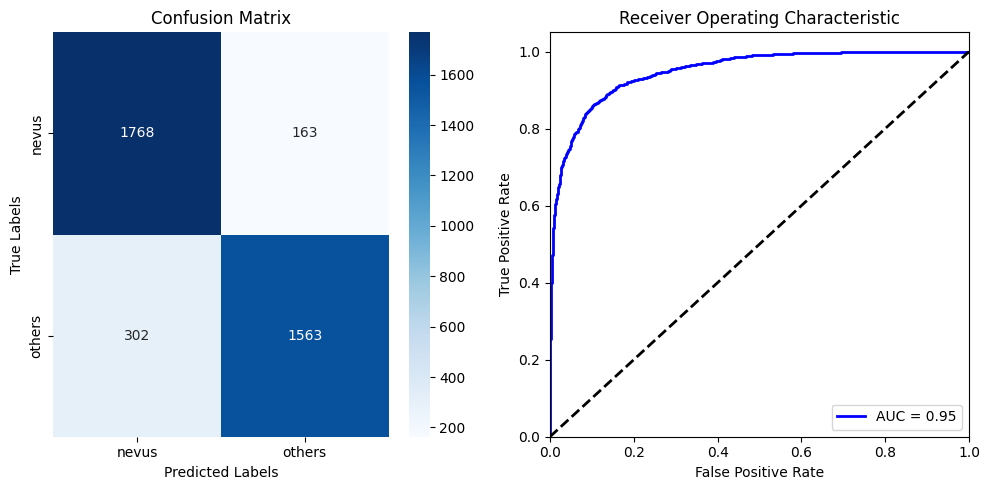

In [26]:
# Use weights=None since we are loading our own weights and not using pretrained weights
resnet34_model_predict = models.resnet34(weights=None)
num_ftrs = resnet34_model_predict.fc.in_features
resnet34_model_predict.fc = nn.Linear(num_ftrs, 1)  # Assuming binary classification

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/resnet34_model.pth'
resnet34_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
resnet34_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Make predictions on the validation data
predicted_probs, true_labels, _, val_acc, val_kappa = predict_model(resnet34_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}\n')

# Ensure class names are in string format
class_list = ["nevus", "others"]

# Plot the evaluation metrics
plot_evaluation_metrics(true_labels, predicted_probs, class_list)


# ResNext50

In [ ]:
# Setup for logging
logging.basicConfig(filename="training_log.txt", level=logging.INFO, force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Creating ResNeXt50 model
model = models.resnext50_32x4d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
resnext50_model = model.to(DEVICE)

# Additional required parameters
LR = 1e-4
WD = 1e-8
EPOCHS = 50

# Loss function, Optimizer, and LR Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

# TensorBoard setup
writer_path  = TENSORBOARD_PATH + '/tensorboard_log'
train_writer = SummaryWriter(writer_path + '/train')
val_writer   = SummaryWriter(writer_path + '/val')

# DataLoaders
dataloaders = {"train": train_loader, "val": val_loader}


# Set your checkpoint path
checkpoint_path = TENSORBOARD_PATH + '/resnext50_checkpoint.pth'

# Check if a checkpoint exists, if so, load it
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    resnext50_model.load_state_dict(checkpoint)  # Load model state

    # Load optimizer and scheduler state if they exist in the checkpoint
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch


# Train the model
summary, metrics = train_model(resnext50_model,
                               dataloaders,
                               criterion,
                               optimizer,
                               lr_scheduler,
                               num_epochs=EPOCHS,
                               checkpoint_path=checkpoint_path,
                               start_epoch=start_epoch)

# Close the train and validation writers
train_writer.close()
val_writer.close()

# Save the final model weights to a file
save_model_path = BEST_MODEL_PATH + '/resnext50_model.pth'

try:
    torch.save(summary.state_dict(), save_model_path)
    print('Model has been saved!')
except Exception as e:
    print(f"Error saving model: {e}")


Epoch 0/49
----------


100%|██████████| 475/475 [1:27:28<00:00, 11.05s/it]


train Loss: 0.2034 Acc: 0.9161


100%|██████████| 119/119 [21:01<00:00, 10.60s/it]


val Loss: 0.2882 Acc: 0.8828
Epoch 1/49
----------


100%|██████████| 475/475 [09:17<00:00,  1.17s/it]


train Loss: 0.1938 Acc: 0.9203


100%|██████████| 119/119 [01:35<00:00,  1.24it/s]


val Loss: 0.2891 Acc: 0.8854
Epoch 2/49
----------


100%|██████████| 475/475 [09:10<00:00,  1.16s/it]


train Loss: 0.1896 Acc: 0.9263


100%|██████████| 119/119 [01:35<00:00,  1.25it/s]


val Loss: 0.2996 Acc: 0.8867
Epoch 3/49
----------


100%|██████████| 475/475 [09:17<00:00,  1.17s/it]


train Loss: 0.1825 Acc: 0.9262


100%|██████████| 119/119 [01:35<00:00,  1.25it/s]


val Loss: 0.3010 Acc: 0.8849
Epoch 4/49
----------


100%|██████████| 475/475 [09:20<00:00,  1.18s/it]


train Loss: 0.1801 Acc: 0.9277


100%|██████████| 119/119 [01:35<00:00,  1.24it/s]


val Loss: 0.3520 Acc: 0.8767
Epoch 5/49
----------


100%|██████████| 475/475 [09:15<00:00,  1.17s/it]


train Loss: 0.1699 Acc: 0.9316


100%|██████████| 119/119 [01:35<00:00,  1.25it/s]


val Loss: 0.2964 Acc: 0.8959
Epoch 6/49
----------


100%|██████████| 475/475 [09:18<00:00,  1.18s/it]


train Loss: 0.1641 Acc: 0.9335


100%|██████████| 119/119 [01:39<00:00,  1.20it/s]


val Loss: 0.2973 Acc: 0.8954
Epoch 7/49
----------


100%|██████████| 475/475 [09:23<00:00,  1.19s/it]


train Loss: 0.1636 Acc: 0.9349


100%|██████████| 119/119 [01:37<00:00,  1.23it/s]


val Loss: 0.3131 Acc: 0.8880
Epoch 8/49
----------


100%|██████████| 475/475 [09:18<00:00,  1.18s/it]


train Loss: 0.1562 Acc: 0.9393


100%|██████████| 119/119 [01:36<00:00,  1.23it/s]


val Loss: 0.2997 Acc: 0.8904
Epoch 9/49
----------


100%|██████████| 475/475 [09:11<00:00,  1.16s/it]


train Loss: 0.1241 Acc: 0.9518


100%|██████████| 119/119 [01:35<00:00,  1.24it/s]


val Loss: 0.3576 Acc: 0.8720
Epoch 10/49
----------


100%|██████████| 475/475 [09:09<00:00,  1.16s/it]


train Loss: 0.1121 Acc: 0.9572


100%|██████████| 119/119 [01:34<00:00,  1.25it/s]


val Loss: 0.3054 Acc: 0.9044
Epoch 11/49
----------


100%|██████████| 475/475 [09:09<00:00,  1.16s/it]


train Loss: 0.0982 Acc: 0.9631


100%|██████████| 119/119 [01:35<00:00,  1.25it/s]


val Loss: 0.3504 Acc: 0.9002

Early stopping
Training complete in 227m 58s
Best val loss: 0.288189
Model has been saved!


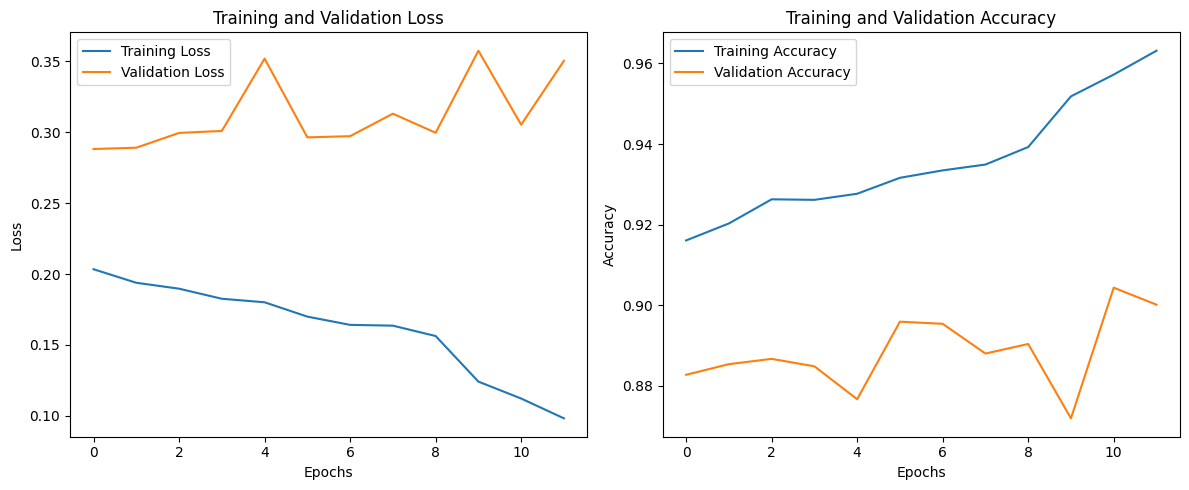

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Define the ResNeXt50 Model Structure
resnext50_model_predict    = models.resnext50_32x4d(weights=None)  # False because we are loading our own weights
num_ftrs                   = resnext50_model_predict.fc.in_features
resnext50_model_predict.fc = nn.Linear(num_ftrs, 1)  # Assuming binary classification

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/resnext50_model.pth'
resnext50_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
resnext50_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Make predictions on the validation data
predictions, true_labels, _, val_acc, val_kappa = predict_model(resnext50_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}')


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


Total prediction time: 91.38 seconds
Validation Accuracy: 0.8828, Validation Kappa: 0.7657


100%|██████████| 119/119 [01:15<00:00,  1.57it/s]



Total prediction time: 75.64 seconds
Validation Accuracy: 0.8828, Validation Kappa: 0.7657





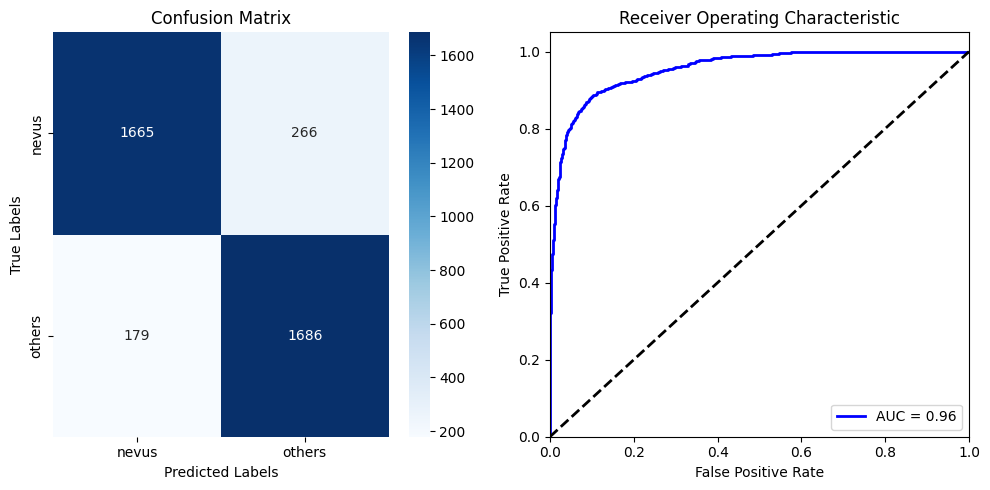

In [27]:
# Define the ResNeXt50 Model Structure
resnext50_model_predict    = models.resnext50_32x4d(weights=None)  # False because we are loading our own weights
num_ftrs                   = resnext50_model_predict.fc.in_features
resnext50_model_predict.fc = nn.Linear(num_ftrs, 1)  # Assuming binary classification

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/resnext50_model.pth'
resnext50_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
resnext50_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Make predictions on the validation data
predicted_probs, true_labels, _, val_acc, val_kappa = predict_model(resnext50_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}\n')

# Ensure class names are in string format
class_list = ["nevus", "others"]

# Plot the evaluation metrics
plot_evaluation_metrics(true_labels, predicted_probs, class_list)



# EfficientNetB2

In [ ]:
# Override the get_state_dict method to bypass hash check
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)  # Remove check_hash if it exists
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# Setup for logging
logging.basicConfig(filename="training_log.txt", level=logging.INFO, force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load EfficientNet B2 with pre-trained weights
model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

# Modify the classifier for binary classification
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)
efficientnet_b2_model = model.to(DEVICE)

# Rest of your training setup (LR, WD, EPOCHS, criterion, optimizer, lr_scheduler)
LR = 1e-4
WD = 1e-8
EPOCHS = 50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

# TensorBoard setup
writer_path  = TENSORBOARD_PATH + '/tensorboard_log'
train_writer = SummaryWriter(writer_path + '/train')
val_writer   = SummaryWriter(writer_path + '/val')

# DataLoaders
dataloaders = {"train": train_loader, "val": val_loader}

# Checkpoint path
checkpoint_path = TENSORBOARD_PATH + '/efficientnet_b2_checkpoint.pth'

# Load checkpoint if it exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    efficientnet_b2_model.load_state_dict(checkpoint)
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1

# Train the model
summary, metrics = train_model(efficientnet_b2_model,
                               dataloaders,
                               criterion,
                               optimizer,
                               lr_scheduler,
                               num_epochs=EPOCHS,
                               checkpoint_path=checkpoint_path,
                               start_epoch=start_epoch)

# Close the train and validation writers
train_writer.close()
val_writer.close()

# Save the final model weights to a file
save_model_path = BEST_MODEL_PATH + '/efficientnet_b2_model.pth'
try:
    torch.save(summary.state_dict(), save_model_path)
    print('Model has been saved!')
except Exception as e:
    print(f"Error saving model: {e}")


Epoch 0/49
----------


100%|██████████| 475/475 [07:45<00:00,  1.02it/s]


train Loss: 0.2012 Acc: 0.9166


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.2698 Acc: 0.8899
Epoch 1/49
----------


100%|██████████| 475/475 [07:33<00:00,  1.05it/s]


train Loss: 0.1798 Acc: 0.9266


100%|██████████| 119/119 [01:30<00:00,  1.31it/s]


val Loss: 0.2818 Acc: 0.8891
Epoch 2/49
----------


100%|██████████| 475/475 [07:34<00:00,  1.05it/s]


train Loss: 0.1720 Acc: 0.9283


100%|██████████| 119/119 [01:29<00:00,  1.32it/s]


val Loss: 0.2920 Acc: 0.8894
Epoch 3/49
----------


100%|██████████| 475/475 [07:27<00:00,  1.06it/s]


train Loss: 0.1690 Acc: 0.9309


100%|██████████| 119/119 [01:29<00:00,  1.33it/s]


val Loss: 0.2836 Acc: 0.8970
Epoch 4/49
----------


100%|██████████| 475/475 [07:30<00:00,  1.05it/s]


train Loss: 0.1528 Acc: 0.9362


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3037 Acc: 0.8946
Epoch 5/49
----------


100%|██████████| 475/475 [07:32<00:00,  1.05it/s]


train Loss: 0.1507 Acc: 0.9387


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.2936 Acc: 0.8930
Epoch 6/49
----------


100%|██████████| 475/475 [07:29<00:00,  1.06it/s]


train Loss: 0.1446 Acc: 0.9425


100%|██████████| 119/119 [01:30<00:00,  1.31it/s]


val Loss: 0.3253 Acc: 0.8825
Epoch 7/49
----------


100%|██████████| 475/475 [07:54<00:00,  1.00it/s]


train Loss: 0.1283 Acc: 0.9496


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


val Loss: 0.3074 Acc: 0.8925
Epoch 8/49
----------


100%|██████████| 475/475 [07:26<00:00,  1.06it/s]


train Loss: 0.1309 Acc: 0.9455


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3104 Acc: 0.9009
Epoch 9/49
----------


100%|██████████| 475/475 [07:31<00:00,  1.05it/s]


train Loss: 0.1058 Acc: 0.9577


100%|██████████| 119/119 [01:31<00:00,  1.31it/s]


val Loss: 0.3070 Acc: 0.9028
Epoch 10/49
----------


100%|██████████| 475/475 [07:32<00:00,  1.05it/s]


train Loss: 0.0960 Acc: 0.9641


100%|██████████| 119/119 [01:30<00:00,  1.32it/s]


val Loss: 0.3070 Acc: 0.9023
Epoch 11/49
----------


100%|██████████| 475/475 [07:31<00:00,  1.05it/s]


train Loss: 0.0908 Acc: 0.9658


100%|██████████| 119/119 [01:30<00:00,  1.31it/s]


val Loss: 0.3228 Acc: 0.9033

Early stopping
Training complete in 108m 58s
Best val loss: 0.269782
Model has been saved!


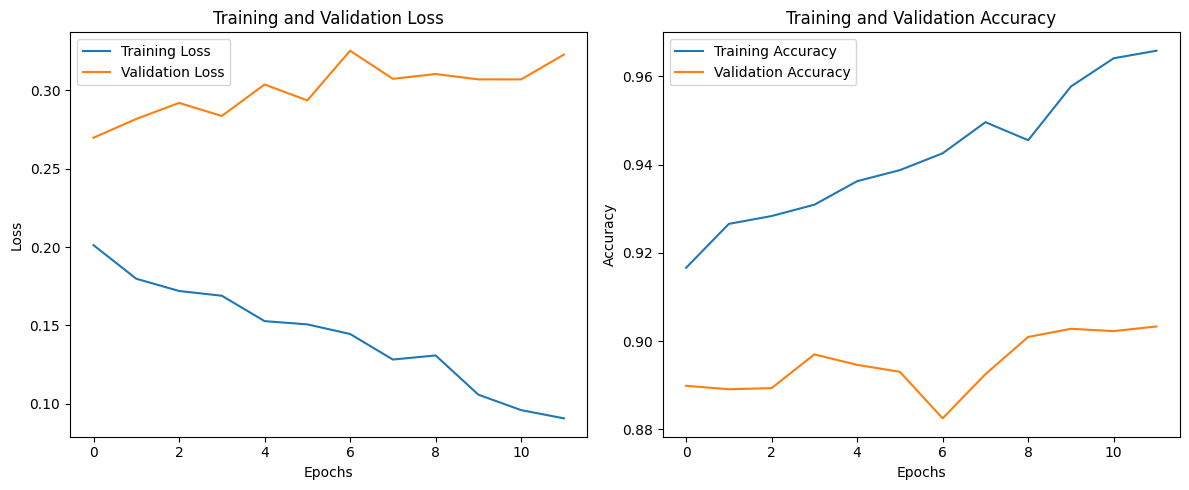

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


100%|██████████| 119/119 [01:14<00:00,  1.61it/s]



Total prediction time: 74.06 seconds
Validation Accuracy: 0.8899, Validation Kappa: 0.7796





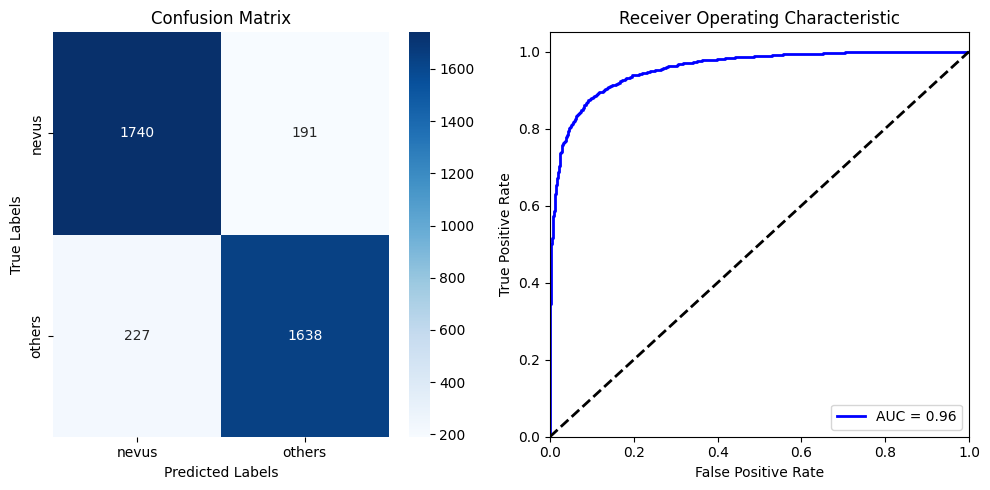

In [28]:
# Define the EfficientNetB2 Model Structure
efficientnetb2_model_predict = models.efficientnet_b2(weights=None)  # No pretrained weights

# The classifier in EfficientNetB2 is a Sequential layer, the last layer of which is a Linear layer
num_ftrs = efficientnetb2_model_predict.classifier[-1].in_features

# Replace the last layer of the classifier with a new Linear layer for binary classification
efficientnetb2_model_predict.classifier[-1] = nn.Linear(num_ftrs, 1)

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/efficientnet_b2_model.pth'
efficientnetb2_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
efficientnetb2_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Make predictions on the validation data
predicted_probs, true_labels, _, val_acc, val_kappa = predict_model(efficientnetb2_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}\n')

# Ensure class names are in string format
class_list = ["nevus", "others"]

# Plot the evaluation metrics
plot_evaluation_metrics(true_labels, predicted_probs, class_list)


# EfficientNetB4

In [ ]:
# Override the get_state_dict method to bypass hash check
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)  # Remove check_hash if it exists
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# Setup for logging
logging.basicConfig(filename="training_log.txt", level=logging.INFO, force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load EfficientNet B2 with pre-trained weights
model = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)

# Modify the classifier for binary classification
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)
efficientnet_b4_model = model.to(DEVICE)

# Rest of your training setup (LR, WD, EPOCHS, criterion, optimizer, lr_scheduler)
LR = 1e-4
WD = 1e-8
EPOCHS = 50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

# TensorBoard setup
writer_path  = TENSORBOARD_PATH + '/tensorboard_log'
train_writer = SummaryWriter(writer_path + '/train')
val_writer   = SummaryWriter(writer_path + '/val')

# DataLoaders
dataloaders = {"train": train_loader, "val": val_loader}

# Checkpoint path
checkpoint_path = TENSORBOARD_PATH + '/efficientnet_b4_checkpoint.pth'

# Load checkpoint if it exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    efficientnet_b4_model.load_state_dict(checkpoint)
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1

# Train the model
summary, metrics = train_model(efficientnet_b4_model,
                               dataloaders,
                               criterion,
                               optimizer,
                               lr_scheduler,
                               num_epochs=EPOCHS,
                               checkpoint_path=checkpoint_path,
                               start_epoch=start_epoch)

# Close the train and validation writers
train_writer.close()
val_writer.close()

# Save the final model weights to a file
save_model_path = BEST_MODEL_PATH + '/efficientnet_b4_model.pth'
try:
    torch.save(summary.state_dict(), save_model_path)
    print('Model has been saved!')
except Exception as e:
    print(f"Error saving model: {e}")


Epoch 0/49
----------


100%|██████████| 950/950 [16:08<00:00,  1.02s/it]


train Loss: 0.2193 Acc: 0.9087


100%|██████████| 238/238 [02:14<00:00,  1.78it/s]


val Loss: 0.2611 Acc: 0.8928
Epoch 1/49
----------


100%|██████████| 950/950 [16:50<00:00,  1.06s/it]


train Loss: 0.2057 Acc: 0.9148


100%|██████████| 238/238 [02:21<00:00,  1.68it/s]


val Loss: 0.2673 Acc: 0.8933
Epoch 2/49
----------


100%|██████████| 950/950 [16:39<00:00,  1.05s/it]


train Loss: 0.1971 Acc: 0.9203


100%|██████████| 238/238 [02:17<00:00,  1.73it/s]


val Loss: 0.2700 Acc: 0.8912
Epoch 3/49
----------


100%|██████████| 950/950 [16:30<00:00,  1.04s/it]


train Loss: 0.1871 Acc: 0.9233


100%|██████████| 238/238 [02:18<00:00,  1.71it/s]


val Loss: 0.2670 Acc: 0.8991
Epoch 4/49
----------


100%|██████████| 950/950 [16:32<00:00,  1.04s/it]


train Loss: 0.1754 Acc: 0.9276


100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


val Loss: 0.2785 Acc: 0.8930
Epoch 5/49
----------


100%|██████████| 950/950 [16:32<00:00,  1.04s/it]


train Loss: 0.1646 Acc: 0.9330


100%|██████████| 238/238 [02:18<00:00,  1.71it/s]


val Loss: 0.2729 Acc: 0.8952
Epoch 6/49
----------


100%|██████████| 950/950 [16:31<00:00,  1.04s/it]


train Loss: 0.1583 Acc: 0.9355


100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


val Loss: 0.2817 Acc: 0.8957
Epoch 7/49
----------


100%|██████████| 950/950 [16:30<00:00,  1.04s/it]


train Loss: 0.1481 Acc: 0.9394


100%|██████████| 238/238 [02:17<00:00,  1.73it/s]


val Loss: 0.2850 Acc: 0.8954
Epoch 8/49
----------


100%|██████████| 950/950 [16:30<00:00,  1.04s/it]


train Loss: 0.1473 Acc: 0.9401


100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


val Loss: 0.2707 Acc: 0.8996
Epoch 9/49
----------


100%|██████████| 950/950 [16:30<00:00,  1.04s/it]


train Loss: 0.1305 Acc: 0.9481


100%|██████████| 238/238 [02:17<00:00,  1.73it/s]


val Loss: 0.2709 Acc: 0.8994
Epoch 10/49
----------


100%|██████████| 950/950 [16:29<00:00,  1.04s/it]


train Loss: 0.1238 Acc: 0.9514


100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


val Loss: 0.2964 Acc: 0.8994
Epoch 11/49
----------


100%|██████████| 950/950 [16:32<00:00,  1.04s/it]


train Loss: 0.1139 Acc: 0.9556


100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


val Loss: 0.3052 Acc: 0.9012

Early stopping
Training complete in 225m 57s
Best val loss: 0.261140
Model has been saved!


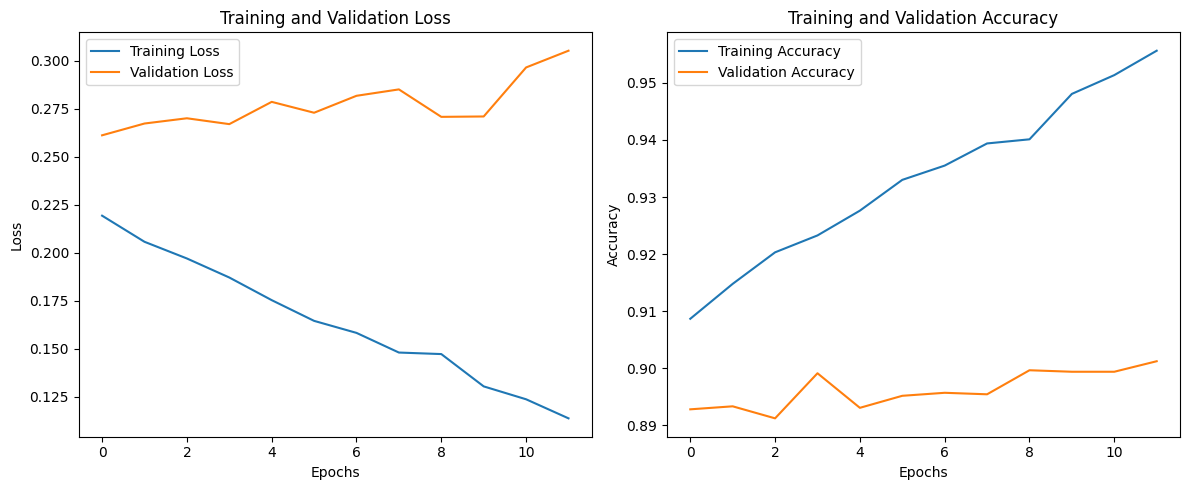

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


100%|██████████| 119/119 [01:16<00:00,  1.55it/s]



Total prediction time: 76.76 seconds
Validation Accuracy: 0.8635, Validation Kappa: 0.7265





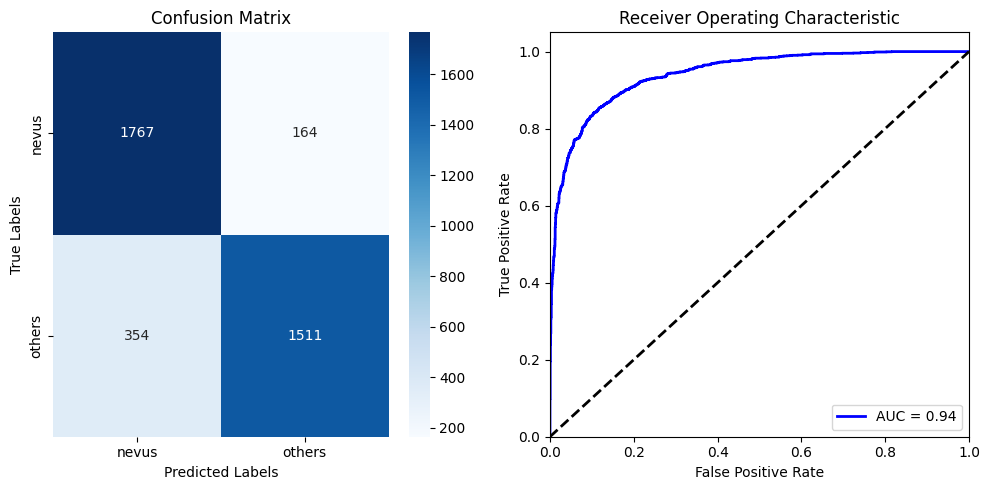

In [29]:
# Define the EfficientNetB4 Model Structure
efficientnetb4_model_predict = models.efficientnet_b4(weights=None)  # No pretrained weights

# The classifier in EfficientNetB4 is a Sequential layer, the last layer of which is a Linear layer
num_ftrs = efficientnetb4_model_predict.classifier[-1].in_features

# Replace the last layer of the classifier with a new Linear layer for binary classification
efficientnetb4_model_predict.classifier[-1] = nn.Linear(num_ftrs, 1)

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/efficientnet_b4_model.pth'
efficientnetb4_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
efficientnetb4_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Make predictions on the validation data
predicted_probs, true_labels, _, val_acc, val_kappa = predict_model(efficientnetb4_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}\n')

# Ensure class names are in string format
class_list = ["nevus", "others"]

# Plot the evaluation metrics
plot_evaluation_metrics(true_labels, predicted_probs, class_list)

# Swin Transformer B

In [ ]:
# Setup for logging
logging.basicConfig(filename="training_log.txt", level=logging.INFO, force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the Swin Transformer model
weights = Swin_B_Weights.DEFAULT
model = swin_b(weights=weights)
num_ftrs = model.head.in_features
model.head = torch.nn.Linear(num_ftrs, 1)
swinb_model = model.to(DEVICE)

# Additional required parameters
LR = 1e-4
WD = 1e-8
EPOCHS = 50

# Loss function, Optimizer, and LR Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

# TensorBoard setup
writer_path  = TENSORBOARD_PATH + '/tensorboard_log'
train_writer = SummaryWriter(writer_path + '/train')
val_writer   = SummaryWriter(writer_path + '/val')

# DataLoaders
dataloaders = {"train": train_loader, "val": val_loader}


# Set your checkpoint path
checkpoint_path = TENSORBOARD_PATH + '/swinb_model_checkpoint.pth'

# Check if a checkpoint exists, if so, load it
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    resnext50_model.load_state_dict(checkpoint)  # Load model state

    # Load optimizer and scheduler state if they exist in the checkpoint
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch


# Train the model
summary, metrics = train_model(swinb_model,
                               dataloaders,
                               criterion,
                               optimizer,
                               lr_scheduler,
                               num_epochs=EPOCHS,
                               checkpoint_path=checkpoint_path,
                               start_epoch=start_epoch)

# Close the train and validation writers
train_writer.close()
val_writer.close()

# Save the final model weights to a file
save_model_path = BEST_MODEL_PATH + '/swinb_model.pth'

try:
    torch.save(summary.state_dict(), save_model_path)
    print('Model has been saved!')
except Exception as e:
    print(f"Error saving model: {e}")


Epoch 0/49
----------


100%|██████████| 475/475 [18:50<00:00,  2.38s/it]


train Loss: 0.4270 Acc: 0.8057


100%|██████████| 119/119 [02:29<00:00,  1.26s/it]


val Loss: 0.3495 Acc: 0.8454
Epoch 1/49
----------


100%|██████████| 475/475 [18:51<00:00,  2.38s/it]


train Loss: 0.3655 Acc: 0.8398


100%|██████████| 119/119 [02:28<00:00,  1.25s/it]


val Loss: 0.3420 Acc: 0.8641
Epoch 2/49
----------


100%|██████████| 475/475 [19:00<00:00,  2.40s/it]


train Loss: 0.3384 Acc: 0.8532


100%|██████████| 119/119 [02:31<00:00,  1.27s/it]


val Loss: 0.3323 Acc: 0.8646
Epoch 3/49
----------


100%|██████████| 475/475 [18:56<00:00,  2.39s/it]


train Loss: 0.3200 Acc: 0.8634


100%|██████████| 119/119 [02:30<00:00,  1.27s/it]


val Loss: 0.3050 Acc: 0.8672
Epoch 4/49
----------


100%|██████████| 475/475 [18:54<00:00,  2.39s/it]


train Loss: 0.3060 Acc: 0.8707


100%|██████████| 119/119 [02:28<00:00,  1.25s/it]


val Loss: 0.3024 Acc: 0.8688
Epoch 5/49
----------


100%|██████████| 475/475 [19:00<00:00,  2.40s/it]


train Loss: 0.2903 Acc: 0.8798


100%|██████████| 119/119 [02:33<00:00,  1.29s/it]


val Loss: 0.2870 Acc: 0.8751
Epoch 6/49
----------


100%|██████████| 475/475 [19:03<00:00,  2.41s/it]


train Loss: 0.2783 Acc: 0.8797


100%|██████████| 119/119 [02:29<00:00,  1.26s/it]


val Loss: 0.3240 Acc: 0.8743
Epoch 7/49
----------


100%|██████████| 475/475 [18:55<00:00,  2.39s/it]


train Loss: 0.2651 Acc: 0.8888


100%|██████████| 119/119 [02:27<00:00,  1.24s/it]


val Loss: 0.2808 Acc: 0.8857
Epoch 8/49
----------


100%|██████████| 475/475 [18:54<00:00,  2.39s/it]


train Loss: 0.2508 Acc: 0.8946


100%|██████████| 119/119 [02:29<00:00,  1.25s/it]


val Loss: 0.2744 Acc: 0.8883
Epoch 9/49
----------


100%|██████████| 475/475 [18:58<00:00,  2.40s/it]


train Loss: 0.2407 Acc: 0.8993


100%|██████████| 119/119 [02:30<00:00,  1.26s/it]


val Loss: 0.2854 Acc: 0.8941
Epoch 10/49
----------


100%|██████████| 475/475 [18:52<00:00,  2.38s/it]


train Loss: 0.2357 Acc: 0.9017


100%|██████████| 119/119 [02:27<00:00,  1.24s/it]


val Loss: 0.2953 Acc: 0.8836
Epoch 11/49
----------


100%|██████████| 475/475 [18:50<00:00,  2.38s/it]


train Loss: 0.2233 Acc: 0.9087


100%|██████████| 119/119 [02:28<00:00,  1.25s/it]


val Loss: 0.2972 Acc: 0.8923
Epoch 12/49
----------


100%|██████████| 475/475 [18:51<00:00,  2.38s/it]


train Loss: 0.2170 Acc: 0.9116


100%|██████████| 119/119 [02:31<00:00,  1.28s/it]


val Loss: 0.2841 Acc: 0.8957
Epoch 13/49
----------


100%|██████████| 475/475 [18:59<00:00,  2.40s/it]


train Loss: 0.2100 Acc: 0.9144


100%|██████████| 119/119 [02:27<00:00,  1.24s/it]


val Loss: 0.3003 Acc: 0.8857
Epoch 14/49
----------


100%|██████████| 475/475 [18:52<00:00,  2.38s/it]


train Loss: 0.2017 Acc: 0.9170


100%|██████████| 119/119 [02:29<00:00,  1.26s/it]


val Loss: 0.3155 Acc: 0.8936
Epoch 15/49
----------


100%|██████████| 475/475 [18:52<00:00,  2.38s/it]


train Loss: 0.1976 Acc: 0.9196


100%|██████████| 119/119 [02:28<00:00,  1.25s/it]


val Loss: 0.2949 Acc: 0.8988
Epoch 16/49
----------


100%|██████████| 475/475 [18:51<00:00,  2.38s/it]


train Loss: 0.1894 Acc: 0.9196


100%|██████████| 119/119 [02:30<00:00,  1.27s/it]


val Loss: 0.2805 Acc: 0.8930
Epoch 17/49
----------


100%|██████████| 475/475 [18:54<00:00,  2.39s/it]


train Loss: 0.1455 Acc: 0.9427


100%|██████████| 119/119 [02:29<00:00,  1.25s/it]


val Loss: 0.2844 Acc: 0.9038
Epoch 18/49
----------


100%|██████████| 475/475 [19:01<00:00,  2.40s/it]


train Loss: 0.1388 Acc: 0.9454


100%|██████████| 119/119 [02:29<00:00,  1.25s/it]


val Loss: 0.2767 Acc: 0.9086
Epoch 19/49
----------


100%|██████████| 475/475 [18:52<00:00,  2.38s/it]


train Loss: 0.1285 Acc: 0.9489


100%|██████████| 119/119 [02:28<00:00,  1.24s/it]


val Loss: 0.3222 Acc: 0.9012

Early stopping
Training complete in 428m 33s
Best val loss: 0.274358
Model has been saved!


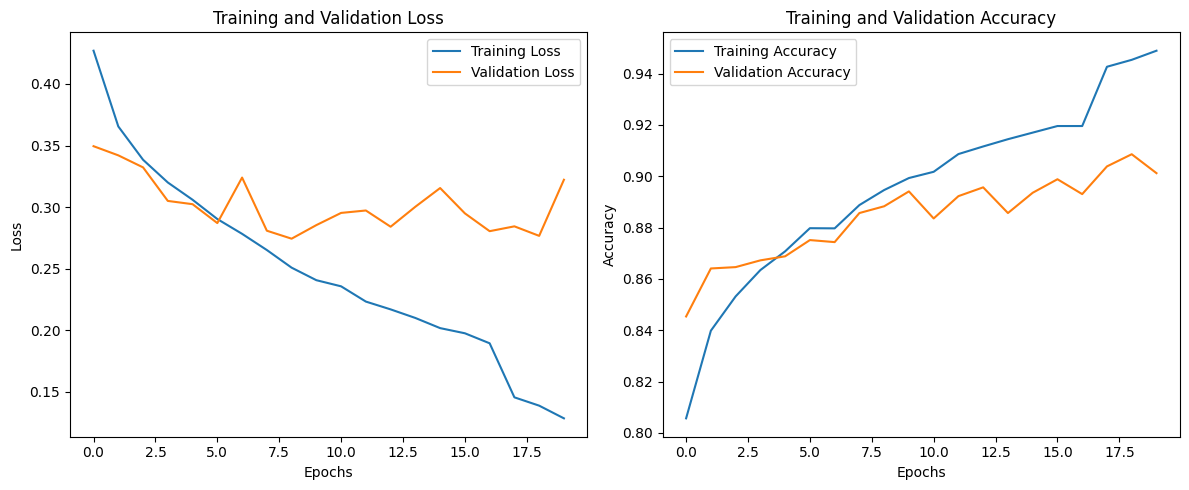

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


100%|██████████| 119/119 [01:36<00:00,  1.23it/s]



Total prediction time: 96.94 seconds
Validation Accuracy: 0.8883, Validation Kappa: 0.7765





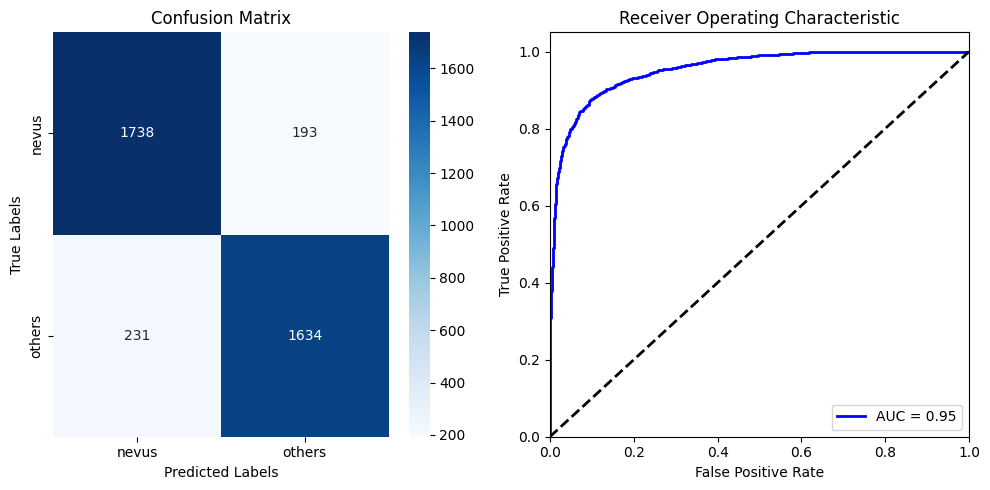

In [30]:
# Define the SwinB Model Structure
swinb_model_predict = models.swin_b(weights=None)  # No pretrained weights

# The head in SwinB is typically a Linear layer for classification
num_ftrs = swinb_model_predict.head.in_features

# Replace the head with a new Linear layer for binary classification
swinb_model_predict.head = nn.Linear(num_ftrs, 1)

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/swinb_model.pth'  # Adjust path as needed
swinb_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
swinb_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Make predictions on the validation data
predicted_probs, true_labels, _, val_acc, val_kappa = predict_model(swinb_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}\n')

# Ensure class names are in string format
class_list = ["nevus", "others"]

# Plot the evaluation metrics
plot_evaluation_metrics(true_labels, predicted_probs, class_list)

# Swim Transformer v2T

In [ ]:
# Setup for logging
logging.basicConfig(filename="training_log.txt", level=logging.INFO, force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the Swin Transformer model
weights = Swin_V2_T_Weights.DEFAULT
model = swin_v2_t(weights=weights)
num_ftrs = model.head.in_features
model.head = torch.nn.Linear(num_ftrs, 1)
swin_v2_t_model = model.to(DEVICE)

# Additional required parameters
LR = 1e-4
WD = 1e-8
EPOCHS = 50

# Loss function, Optimizer, and LR Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

# TensorBoard setup
writer_path  = TENSORBOARD_PATH + '/tensorboard_log'
train_writer = SummaryWriter(writer_path + '/train')
val_writer   = SummaryWriter(writer_path + '/val')

# DataLoaders
dataloaders = {"train": train_loader, "val": val_loader}


# Set your checkpoint path
checkpoint_path = TENSORBOARD_PATH + '/swin_v2_t_model_checkpoint.pth'

# Check if a checkpoint exists, if so, load it
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    resnext50_model.load_state_dict(checkpoint)  # Load model state

    # Load optimizer and scheduler state if they exist in the checkpoint
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if 'epoch' in checkpoint:
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch


# Train the model
summary, metrics = train_model(swin_v2_t_model,
                               dataloaders,
                               criterion,
                               optimizer,
                               lr_scheduler,
                               num_epochs=EPOCHS,
                               checkpoint_path=checkpoint_path,
                               start_epoch=start_epoch)

# Close the train and validation writers
train_writer.close()
val_writer.close()

# Save the final model weights to a file
save_model_path = BEST_MODEL_PATH + '/swin_v2_t_model_model.pth'

try:
    torch.save(summary.state_dict(), save_model_path)
    print('Model has been saved!')
except Exception as e:
    print(f"Error saving model: {e}")


Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:01<00:00, 66.5MB/s]


Epoch 0/49
----------


100%|██████████| 950/950 [11:01<00:00,  1.44it/s]


train Loss: 0.4413 Acc: 0.8005


100%|██████████| 238/238 [01:55<00:00,  2.06it/s]


val Loss: 0.3846 Acc: 0.8166
Epoch 1/49
----------


100%|██████████| 950/950 [10:40<00:00,  1.48it/s]


train Loss: 0.3813 Acc: 0.8340


100%|██████████| 238/238 [01:57<00:00,  2.03it/s]


val Loss: 0.3320 Acc: 0.8535
Epoch 2/49
----------


100%|██████████| 950/950 [10:36<00:00,  1.49it/s]


train Loss: 0.3552 Acc: 0.8467


100%|██████████| 238/238 [01:52<00:00,  2.11it/s]


val Loss: 0.3543 Acc: 0.8472
Epoch 3/49
----------


100%|██████████| 950/950 [10:09<00:00,  1.56it/s]


train Loss: 0.3397 Acc: 0.8563


100%|██████████| 238/238 [01:45<00:00,  2.26it/s]


val Loss: 0.3153 Acc: 0.8620
Epoch 4/49
----------


100%|██████████| 950/950 [09:58<00:00,  1.59it/s]


train Loss: 0.3238 Acc: 0.8595


100%|██████████| 238/238 [01:46<00:00,  2.23it/s]


val Loss: 0.3293 Acc: 0.8617
Epoch 5/49
----------


100%|██████████| 950/950 [09:59<00:00,  1.59it/s]


train Loss: 0.3126 Acc: 0.8658


100%|██████████| 238/238 [01:46<00:00,  2.24it/s]


val Loss: 0.2915 Acc: 0.8770
Epoch 6/49
----------


100%|██████████| 950/950 [10:12<00:00,  1.55it/s]


train Loss: 0.3022 Acc: 0.8725


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


val Loss: 0.3445 Acc: 0.8630
Epoch 7/49
----------


100%|██████████| 950/950 [10:22<00:00,  1.53it/s]


train Loss: 0.2930 Acc: 0.8754


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


val Loss: 0.3025 Acc: 0.8707
Epoch 8/49
----------


100%|██████████| 950/950 [10:20<00:00,  1.53it/s]


train Loss: 0.2768 Acc: 0.8833


100%|██████████| 238/238 [01:52<00:00,  2.12it/s]


val Loss: 0.3059 Acc: 0.8793
Epoch 9/49
----------


100%|██████████| 950/950 [10:21<00:00,  1.53it/s]


train Loss: 0.2720 Acc: 0.8862


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


val Loss: 0.3009 Acc: 0.8764
Epoch 10/49
----------


100%|██████████| 950/950 [10:13<00:00,  1.55it/s]


train Loss: 0.2627 Acc: 0.8881


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


val Loss: 0.2904 Acc: 0.8820
Epoch 11/49
----------


100%|██████████| 950/950 [10:15<00:00,  1.54it/s]


train Loss: 0.2599 Acc: 0.8904


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


val Loss: 0.2876 Acc: 0.8786
Epoch 12/49
----------


100%|██████████| 950/950 [10:19<00:00,  1.53it/s]


train Loss: 0.2512 Acc: 0.8957


100%|██████████| 238/238 [01:49<00:00,  2.18it/s]


val Loss: 0.3129 Acc: 0.8783
Epoch 13/49
----------


100%|██████████| 950/950 [10:15<00:00,  1.54it/s]


train Loss: 0.2407 Acc: 0.8996


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


val Loss: 0.3004 Acc: 0.8678
Epoch 14/49
----------


100%|██████████| 950/950 [10:14<00:00,  1.54it/s]


train Loss: 0.2335 Acc: 0.9021


100%|██████████| 238/238 [01:48<00:00,  2.19it/s]


val Loss: 0.2836 Acc: 0.8812
Epoch 15/49
----------


100%|██████████| 950/950 [10:12<00:00,  1.55it/s]


train Loss: 0.2280 Acc: 0.9067


100%|██████████| 238/238 [01:47<00:00,  2.21it/s]


val Loss: 0.2795 Acc: 0.8870
Epoch 16/49
----------


100%|██████████| 950/950 [10:10<00:00,  1.56it/s]


train Loss: 0.2237 Acc: 0.9102


100%|██████████| 238/238 [01:46<00:00,  2.23it/s]


val Loss: 0.2853 Acc: 0.8841
Epoch 17/49
----------


100%|██████████| 950/950 [10:10<00:00,  1.56it/s]


train Loss: 0.2158 Acc: 0.9150


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


val Loss: 0.3054 Acc: 0.8865
Epoch 18/49
----------


100%|██████████| 950/950 [10:07<00:00,  1.56it/s]


train Loss: 0.2113 Acc: 0.9147


100%|██████████| 238/238 [01:47<00:00,  2.22it/s]


val Loss: 0.2860 Acc: 0.8872
Epoch 19/49
----------


100%|██████████| 950/950 [10:07<00:00,  1.56it/s]


train Loss: 0.2073 Acc: 0.9137


100%|██████████| 238/238 [01:47<00:00,  2.22it/s]


val Loss: 0.2746 Acc: 0.8928
Epoch 20/49
----------


100%|██████████| 950/950 [10:10<00:00,  1.56it/s]


train Loss: 0.2027 Acc: 0.9185


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


val Loss: 0.2849 Acc: 0.8920
Epoch 21/49
----------


100%|██████████| 950/950 [10:15<00:00,  1.54it/s]


train Loss: 0.1947 Acc: 0.9233


100%|██████████| 238/238 [01:53<00:00,  2.10it/s]


val Loss: 0.2511 Acc: 0.8957
Epoch 22/49
----------


100%|██████████| 950/950 [10:26<00:00,  1.52it/s]


train Loss: 0.1861 Acc: 0.9255


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


val Loss: 0.2993 Acc: 0.8930
Epoch 23/49
----------


100%|██████████| 950/950 [10:19<00:00,  1.53it/s]


train Loss: 0.1811 Acc: 0.9247


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


val Loss: 0.3428 Acc: 0.8865
Epoch 24/49
----------


100%|██████████| 950/950 [10:19<00:00,  1.53it/s]


train Loss: 0.1797 Acc: 0.9288


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


val Loss: 0.2898 Acc: 0.8901
Epoch 25/49
----------


100%|██████████| 950/950 [10:19<00:00,  1.53it/s]


train Loss: 0.1756 Acc: 0.9296


100%|██████████| 238/238 [01:49<00:00,  2.16it/s]


val Loss: 0.2654 Acc: 0.8946
Epoch 26/49
----------


100%|██████████| 950/950 [10:19<00:00,  1.53it/s]


train Loss: 0.1732 Acc: 0.9321


100%|██████████| 238/238 [01:47<00:00,  2.21it/s]


val Loss: 0.2706 Acc: 0.8944
Epoch 27/49
----------


100%|██████████| 950/950 [10:21<00:00,  1.53it/s]


train Loss: 0.1651 Acc: 0.9337


100%|██████████| 238/238 [01:47<00:00,  2.22it/s]


val Loss: 0.3212 Acc: 0.8936
Epoch 28/49
----------


100%|██████████| 950/950 [10:25<00:00,  1.52it/s]


train Loss: 0.1569 Acc: 0.9355


100%|██████████| 238/238 [01:52<00:00,  2.12it/s]


val Loss: 0.2774 Acc: 0.8899
Epoch 29/49
----------


100%|██████████| 950/950 [10:32<00:00,  1.50it/s]


train Loss: 0.1636 Acc: 0.9337


100%|██████████| 238/238 [01:54<00:00,  2.09it/s]


val Loss: 0.2709 Acc: 0.8957
Epoch 30/49
----------


100%|██████████| 950/950 [10:32<00:00,  1.50it/s]


train Loss: 0.1189 Acc: 0.9534


100%|██████████| 238/238 [01:52<00:00,  2.12it/s]


val Loss: 0.3060 Acc: 0.9028
Epoch 31/49
----------


100%|██████████| 950/950 [10:25<00:00,  1.52it/s]


train Loss: 0.1098 Acc: 0.9560


100%|██████████| 238/238 [01:53<00:00,  2.09it/s]


val Loss: 0.3054 Acc: 0.9020
Epoch 32/49
----------


100%|██████████| 950/950 [10:29<00:00,  1.51it/s]


train Loss: 0.1008 Acc: 0.9601


100%|██████████| 238/238 [01:54<00:00,  2.08it/s]


val Loss: 0.3008 Acc: 0.8986

Early stopping
Training complete in 401m 22s
Best val loss: 0.251091
Model has been saved!


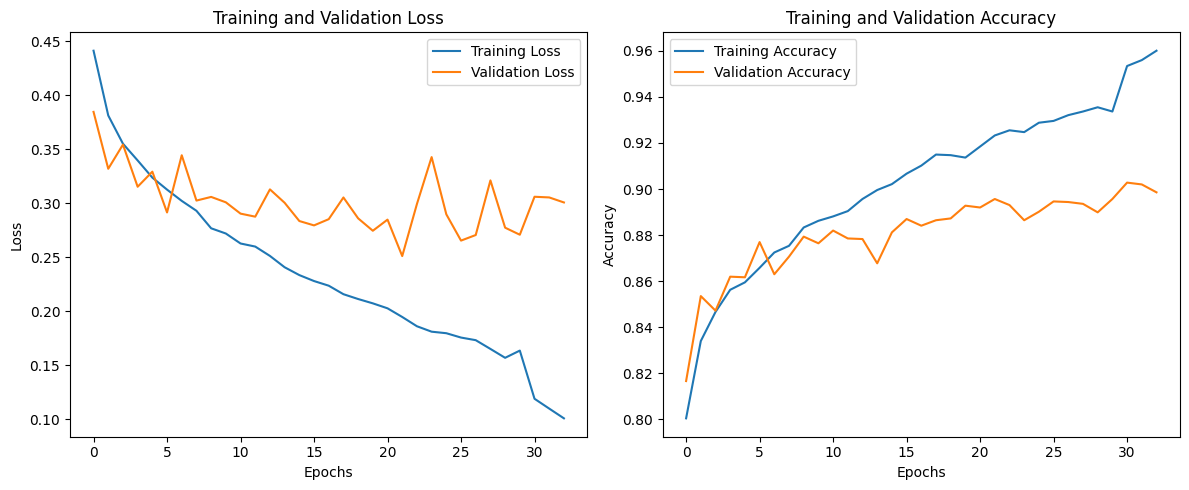

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


100%|██████████| 119/119 [01:18<00:00,  1.51it/s]



Total prediction time: 78.58 seconds
Validation Accuracy: 0.8957, Validation Kappa: 0.7912





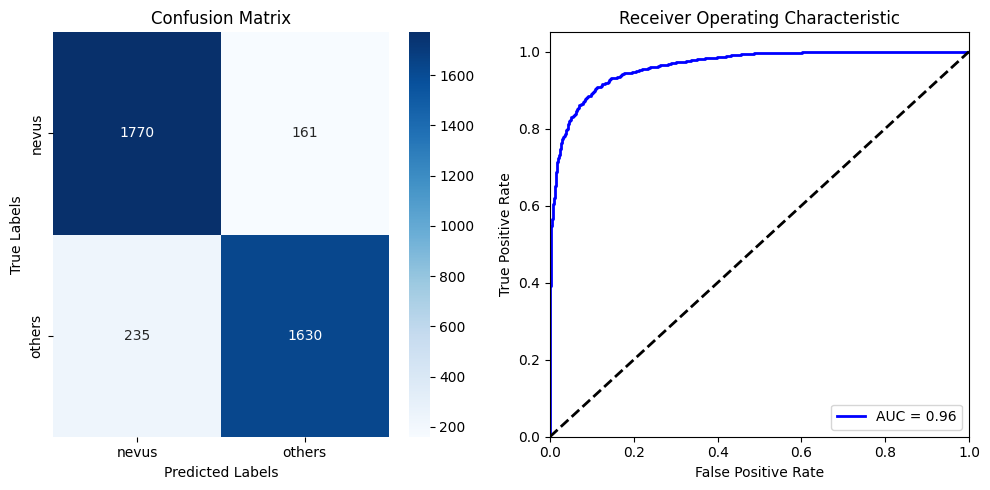

In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

swin_v2_t_model_predict = models.swin_v2_t(weights=None)  # No pretrained weights

# The head in SwinB is typically a Linear layer for classification
num_ftrs = swin_v2_t_model_predict.head.in_features

# Replace the head with a new Linear layer for binary classification
swin_v2_t_model_predict.head = nn.Linear(num_ftrs, 1)

# Load the best model weights
best_model_path = BEST_MODEL_PATH + '/swin_v2_t_model_model.pth'  # Adjust path as needed
swin_v2_t_model_predict.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Move the model to the appropriate device
swin_v2_t_model_predict.to(DEVICE)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()


# Make predictions on the validation data
predicted_probs, true_labels, _, val_acc, val_kappa = predict_model(swin_v2_t_model_predict, val_loader, criterion)

print(f'Validation Accuracy: {val_acc:.4f}, Validation Kappa: {val_kappa:.4f}\n')

# Ensure class names are in string format
class_list = ["nevus", "others"]

# Plot the evaluation metrics
plot_evaluation_metrics(true_labels, predicted_probs, class_list)


# Ensmebles

In [35]:
def ensemble_predictions(dataloader, models, device):
    start_time = time.time()  # Start time for measuring prediction duration

    for model in models:
        model.eval()

    all_preds = []
    all_probs = []  # Store averaged probabilities
    all_labels = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Predicting"):
            if len(data) == 2:
                inputs, labels = data
            elif len(data) == 3:
                inputs, labels, _ = data
            else:
                raise ValueError("Data loader output format not recognized")

            inputs = inputs.to(device)
            labels = labels.to(device)

            ensemble_outputs = 0
            for model in models:
                outputs = torch.sigmoid(model(inputs))
                ensemble_outputs += outputs

            # Average the predictions
            ensemble_avg_probs = ensemble_outputs / len(models)
            all_probs.extend(ensemble_avg_probs.cpu().numpy())

            # Apply majority voting for binary predictions
            ensemble_preds = ensemble_avg_probs.round()
            all_preds.extend(ensemble_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()  # End time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"\nPrediction completed in {elapsed_time:.2f} seconds")

    return all_preds, all_probs, all_labels


In [32]:
DEVICE = 'cuda'
# Define and load the ResNet34 model
best_resnet34_model = models.resnet34(weights=None)  # Set weights to None
num_ftrs_resnet34 = best_resnet34_model.fc.in_features
best_resnet34_model.fc = nn.Linear(num_ftrs_resnet34, 1)  # Assuming binary classification
best_resnet34_model_path = BEST_MODEL_PATH + '/resnet34_model.pth'
_ = best_resnet34_model.load_state_dict(torch.load(best_resnet34_model_path, map_location=DEVICE))  # Load weights
best_resnet34_model.to(DEVICE)
print('ResNet34 model has been uploaded!')

# Define and load the ResNeXt50 model
best_resnext50_model = models.resnext50_32x4d(weights=None)  # Set weights to None
num_ftrs_resnext50 = best_resnext50_model.fc.in_features
best_resnext50_model.fc = nn.Linear(num_ftrs_resnext50, 1)  # Assuming binary classification
best_resnext50_model_path = BEST_MODEL_PATH + '/resnext50_model.pth'
_ = best_resnext50_model.load_state_dict(torch.load(best_resnext50_model_path, map_location=DEVICE))  # Load weights
best_resnext50_model.to(DEVICE)
print('ResNext50 model has been uploaded!')

# Define and load the EfficientNetB2 model
best_efficientnetb2_model = models.efficientnet_b2(weights=None)
num_ftrs_efficientnetb2 = best_efficientnetb2_model.classifier[1].in_features
best_efficientnetb2_model.classifier[1] = nn.Linear(num_ftrs_efficientnetb2, 1)
best_efficientnetb2_model_path = BEST_MODEL_PATH + '/efficientnet_b2_model.pth'
_ = best_efficientnetb2_model.load_state_dict(torch.load(best_efficientnetb2_model_path, map_location=DEVICE))
best_efficientnetb2_model.to(DEVICE)
print('EfficientNetB2 model has been uploaded!')

# Define and load the EfficientNetB2 model
best_efficientnetb4_model = models.efficientnet_b4(weights=None)
num_ftrs_efficientnetb4 = best_efficientnetb4_model.classifier[1].in_features
best_efficientnetb4_model.classifier[1] = nn.Linear(num_ftrs_efficientnetb4, 1)
best_efficientnetb4_model_path = BEST_MODEL_PATH + '/efficientnet_b4_model.pth'
_ = best_efficientnetb4_model.load_state_dict(torch.load(best_efficientnetb4_model_path, map_location=DEVICE))
best_efficientnetb4_model.to(DEVICE)
print('EfficientNetB4 model has been uploaded!')

# Define and load the SwinB model
best_swinb_model = swin_b(weights=None)  # No pretrained weights
num_ftrs_swinb = best_swinb_model.head.in_features
best_swinb_model.head = nn.Linear(num_ftrs_swinb, 1)
best_swinb_model_path = BEST_MODEL_PATH + '/swinb_model.pth'  # Adjust the path as needed
_ = best_swinb_model.load_state_dict(torch.load(best_swinb_model_path, map_location=DEVICE))
best_swinb_model.to(DEVICE)
print('SwinTransformerB model has been uploaded!')


# Define and load the SwinV2T model
best_swinv2t_model = swin_v2_t_model(weights=None)  # No pretrained weights
num_ftrs_swinv2t = best_swinv2t_model.head.in_features
best_swinv2t_model.head = nn.Linear(num_ftrs_swinv2t, 1)
best_swinv2t_model_path = BEST_MODEL_PATH + '/swin_v2_t_model_model.pth'  # Adjust the path as needed
_ = best_swinv2t_model.load_state_dict(torch.load(best_swinv2t_model_path, map_location=DEVICE))
best_swinv2t_model.to(DEVICE)
print('Swin Transformer V2 Tiny model has been uploaded!')



ResNet34 model has been uploaded!
ResNext50 model has been uploaded!
EfficientNetB2 model has been uploaded!
EfficientNetB4 model has been uploaded!
SwinTransformerB model has been uploaded!
Swin Transformer V2 Tiny model has been uploaded!


Predicting: 100%|██████████| 119/119 [01:45<00:00,  1.13it/s]



Prediction completed in 105.22 seconds
Accuracy: 0.9017
Kappa: 0.8033




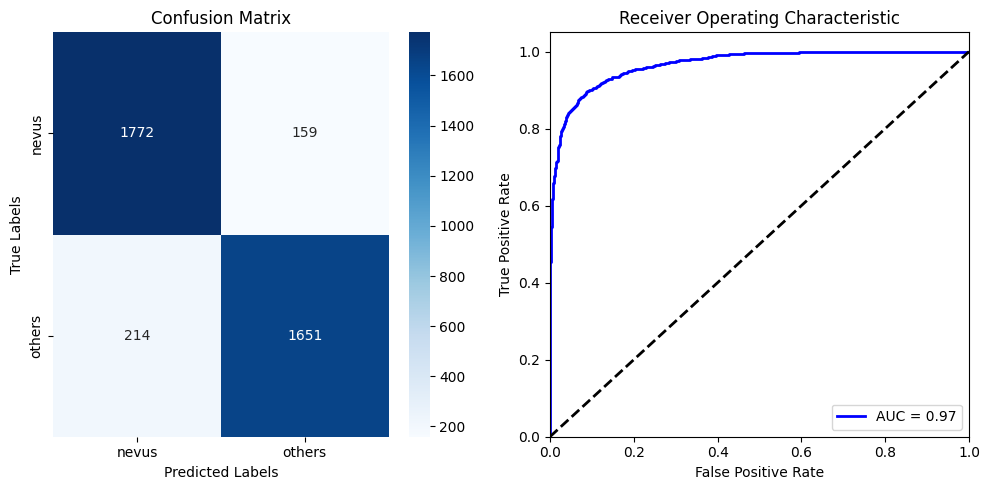

In [37]:
# List of models for ensemble
model_list = [best_resnet34_model, best_resnext50_model, best_efficientnetb2_model, best_swinb_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)


Predicting: 100%|██████████| 119/119 [01:51<00:00,  1.07it/s]



Prediction completed in 111.29 seconds
Accuracy: 0.9060
Kappa: 0.8118




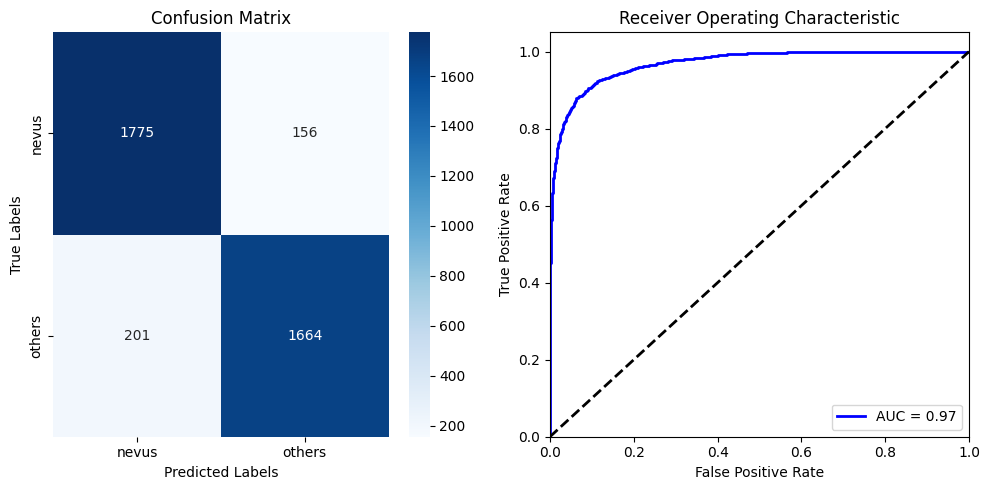

In [38]:
# List of models for ensemble
model_list = [best_resnet34_model, best_resnext50_model, best_efficientnetb2_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:51<00:00,  1.07it/s]



Prediction completed in 111.48 seconds
Accuracy: 0.9038
Kappa: 0.8075




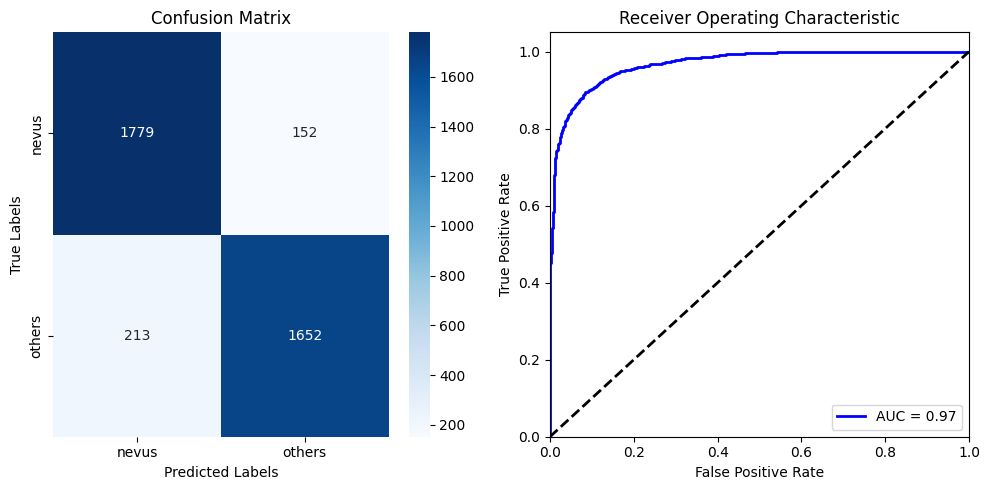

In [39]:
# List of models for ensemble
model_list = [best_resnext50_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:53<00:00,  1.05it/s]



Prediction completed in 113.39 seconds
Accuracy: 0.9070
Kappa: 0.8139




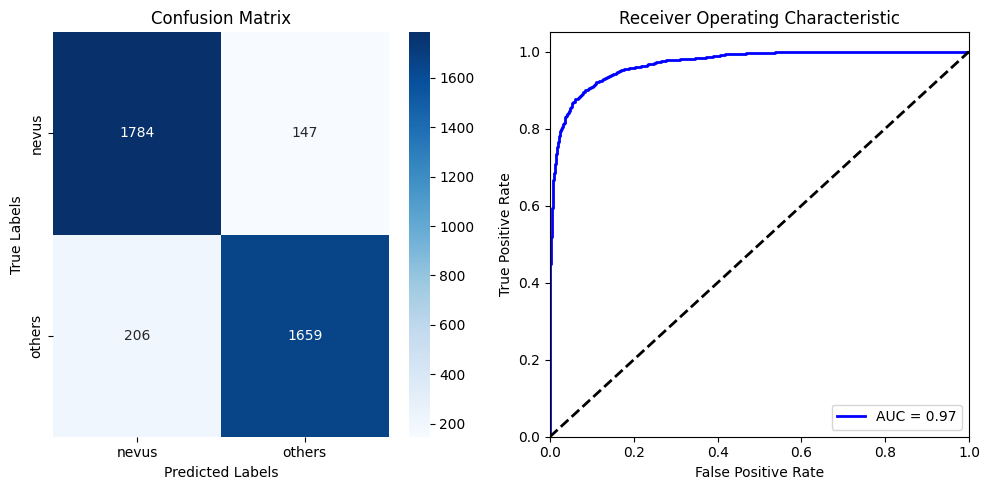

In [40]:
# List of models for ensemble
model_list = [best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:55<00:00,  1.03it/s]



Prediction completed in 115.25 seconds
Accuracy: 0.9070
Kappa: 0.8139




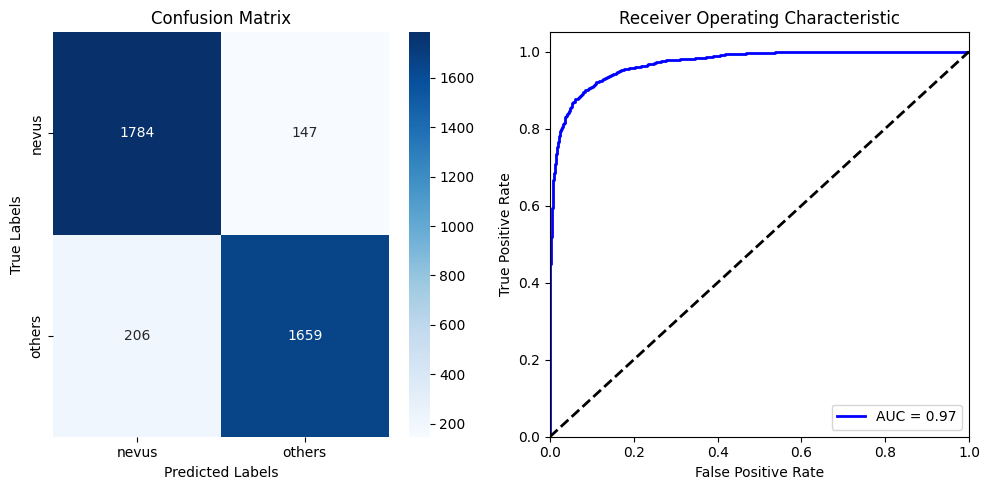

In [36]:
# List of models for ensemble
model_list = [best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:56<00:00,  1.02it/s]



Prediction completed in 116.28 seconds
Accuracy: 0.9057
Kappa: 0.8112




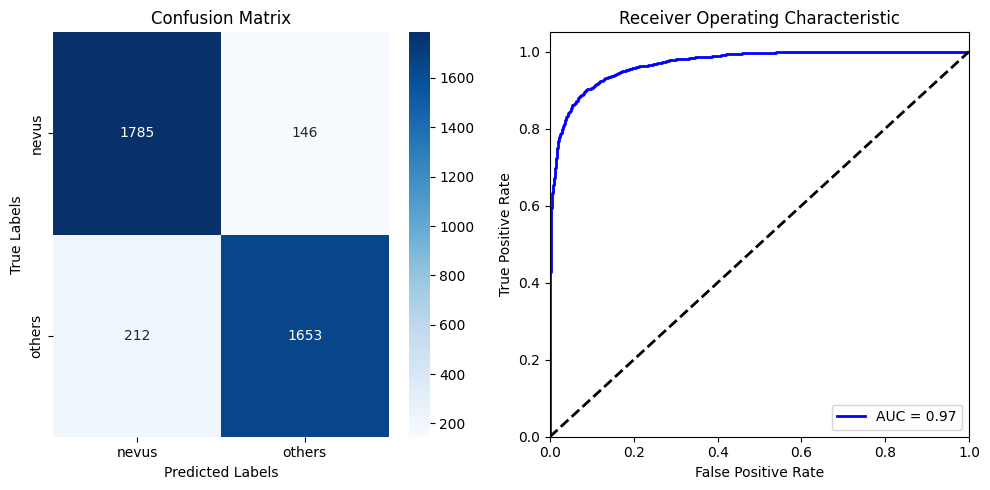

In [41]:
# List of models for ensemble
model_list = [best_resnet34_model, best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:50<00:00,  1.08it/s]



Prediction completed in 110.09 seconds
Accuracy: 0.9046
Kappa: 0.8090




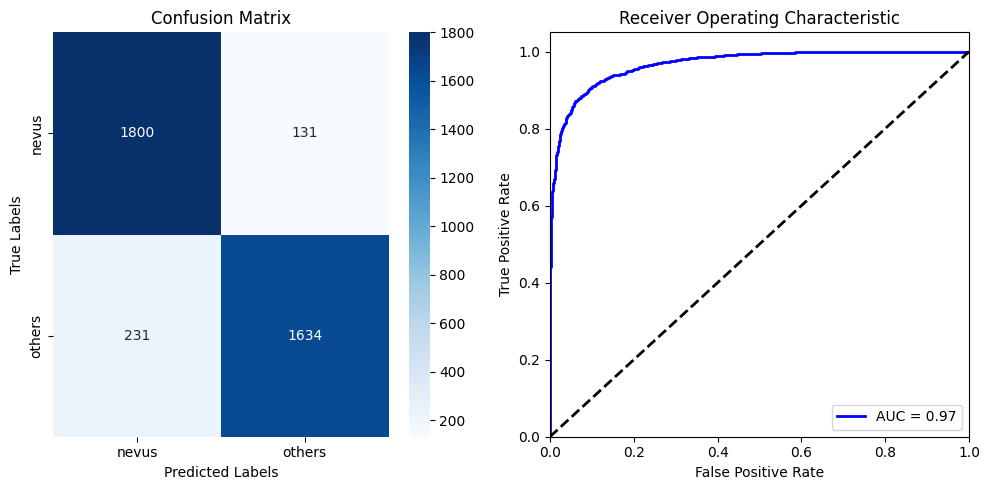

In [42]:
# List of models for ensemble
model_list = [best_resnet34_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:48<00:00,  1.10it/s]



Prediction completed in 108.36 seconds
Accuracy: 0.9065
Kappa: 0.8128




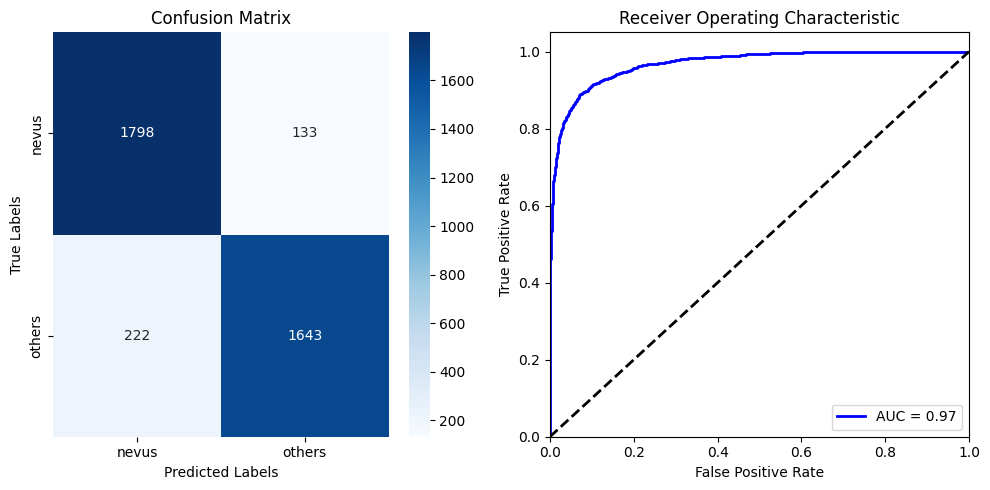

In [43]:
# List of models for ensemble
model_list = [best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:57<00:00,  1.02it/s]



Prediction completed in 117.17 seconds
Accuracy: 0.8975
Kappa: 0.7948




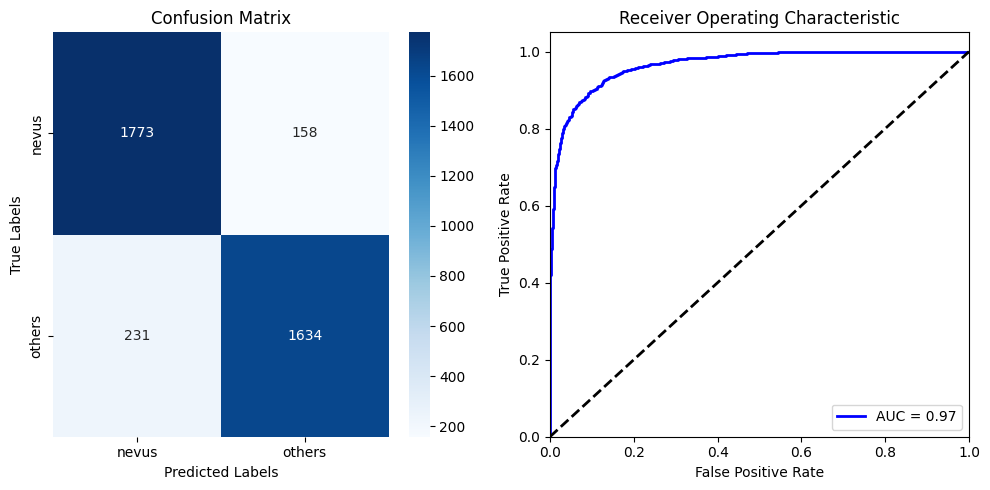

In [44]:
# List of models for ensemble
model_list = [best_resnext50_model, best_efficientnetb4_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:57<00:00,  1.01it/s]



Prediction completed in 117.38 seconds
Accuracy: 0.9057
Kappa: 0.8112




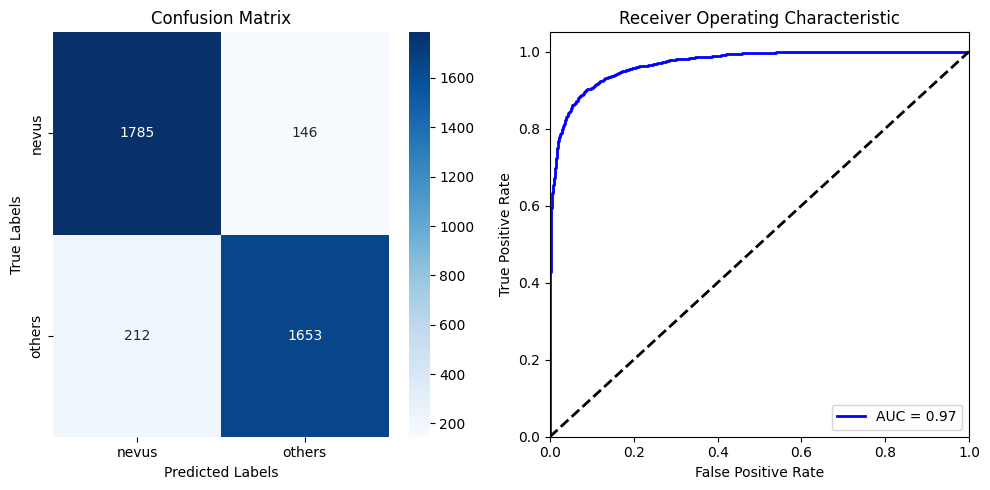

In [45]:
# List of models for ensemble
model_list = [best_resnet34_model, best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:56<00:00,  1.02it/s]



Prediction completed in 116.24 seconds
Accuracy: 0.9057
Kappa: 0.8112




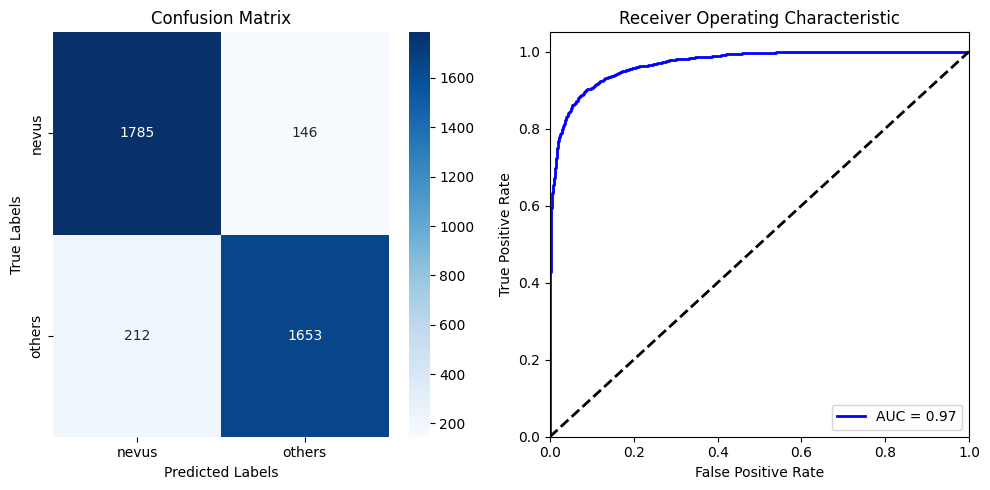

In [46]:
# List of models for ensemble
model_list = [best_resnet34_model, best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

Predicting: 100%|██████████| 119/119 [01:45<00:00,  1.13it/s]



Prediction completed in 105.65 seconds
Accuracy: 0.9007
Kappa: 0.8011




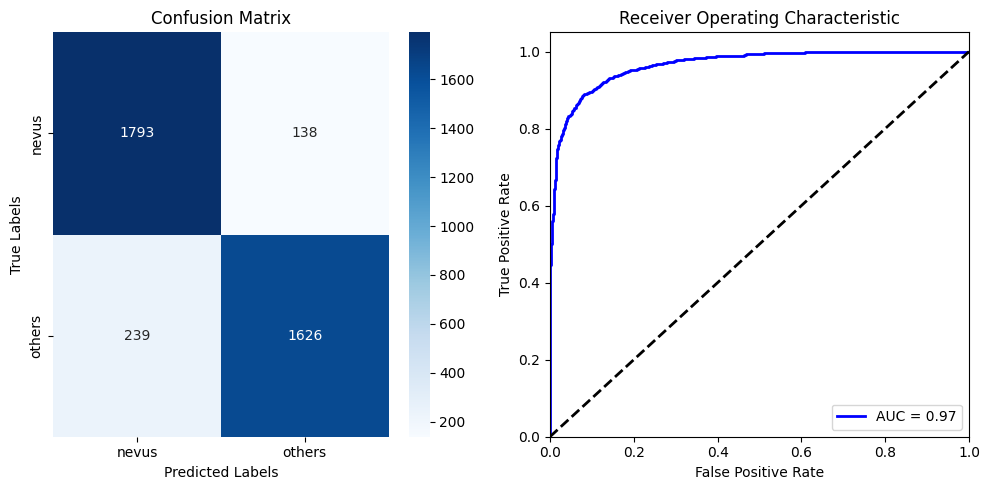

In [47]:
# List of models for ensemble
model_list = [best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions with probabilities
predictions, probabilities, actual_labels = ensemble_predictions(val_loader, model_list, DEVICE)

# Compute accuracy and Cohen's Kappa
accuracy = accuracy_score(actual_labels, predictions)
kappa = cohen_kappa_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')

# Plot the evaluation metrics
class_list = ["nevus", "others"]
plot_evaluation_metrics(actual_labels, probabilities, class_list)

# Prediction Validation dataset with best model


In [ ]:
def ensemble_prediction_for_test(dataloader, models, device):
    for model in models:
        model.eval()

    all_preds = []
    all_file_names = []

    start_time = time.time()

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Predicting"):
            if len(data) == 2:
                inputs, file_paths = data
            else:
                raise ValueError("Data loader output format not recognized")

            inputs = inputs.to(device)

            ensemble_outputs = 0
            for model in models:
                outputs = torch.sigmoid(model(inputs))
                ensemble_outputs += outputs

            ensemble_outputs /= len(models)
            preds = ensemble_outputs.round()

            file_names = [Path(path).stem for path in file_paths]
            sorted_pairs = sorted(zip(file_names, preds.cpu().numpy()), key=lambda x: x[0])
            sorted_file_names, sorted_preds = zip(*sorted_pairs)

            all_file_names.extend(sorted_file_names)
            all_preds.extend(sorted_preds)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nPrediction completed in {elapsed_time:.2f} seconds")

    return all_file_names, all_preds

# List of models for ensemble
model_list = [best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Making ensemble predictions for test data
file_names, predictions = ensemble_prediction_for_test(test_loader, model_list, DEVICE)

# Create DataFrame outside function
test_predictions_df = pd.DataFrame({
    'FileName': file_names,
    'PredictedLabel': [pred[0] for pred in predictions]  # Assuming binary classification
})

# Save to CSV
test_predictions_df.to_csv('test_predictions_test.csv', index=False)


Predicting: 100%|██████████| 199/199 [03:19<00:00,  1.00s/it]


Prediction completed in 199.80 seconds


In [ ]:
def ensemble_prediction_for_test(dataloader, models, device):
    for model in models:
        model.eval()

    all_preds = []
    all_file_names = []

    start_time = time.time()

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Predicting"):
            if len(data) == 2:
                inputs, file_paths = data
            else:
                raise ValueError("Data loader output format not recognized")

            inputs = inputs.to(device)

            ensemble_outputs = 0
            for model in models:
                outputs = torch.sigmoid(model(inputs))
                ensemble_outputs += outputs

            ensemble_outputs /= len(models)
            preds = ensemble_outputs.round()

            file_names = [Path(path).stem for path in file_paths]
            # Flatten the predictions to 0 or 1
            flattened_preds = [int(p[0].item()) for p in preds]

            sorted_pairs = sorted(zip(file_names, flattened_preds), key=lambda x: x[0])
            sorted_file_names, sorted_preds = zip(*sorted_pairs)

            all_file_names.extend(sorted_file_names)
            all_preds.extend(sorted_preds)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nPrediction completed in {elapsed_time:.2f} seconds")

    return all_file_names, all_preds

# List of models for ensemble
model_list = [best_resnext50_model, best_efficientnetb2_model, best_efficientnetb4_model, best_swinb_model, best_swinv2t_model]

# Assuming DEVICE is defined (e.g., 'cuda' or 'cpu')
DEVICE = 'cuda'  # or 'cpu'

# Assuming test_loader is defined and properly set up
# test_loader = DataLoader(...)

# Making ensemble predictions for test data
file_names, predictions = ensemble_prediction_for_test(test_loader, model_list, DEVICE)

# Create DataFrame outside function
test_predictions_df = pd.DataFrame({
    'FileName': file_names,
    'PredictedLabel': predictions  # Directly using predictions
})

# Save to CSV
test_predictions_df.to_csv('test_predictions_test33.csv', index=False)


Predicting: 100%|██████████| 199/199 [03:12<00:00,  1.03it/s]



Prediction completed in 192.68 seconds
